# Statistical comparison for all models studied

## Previous


Esta celda detecta si el código se ejecuta en **Google Colab** o localmente, configura rutas base para guardar datasets y modelos, y crea los directorios necesarios si no existen.


In [1]:
from pathlib import Path
import os
import IPython

def detectar_entorno_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

def configurar_rutas(base_local=None, base_colab="/content/drive/MyDrive/ia_thermal_colab", verbose=True):
    IN_COLAB = detectar_entorno_colab()

    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/drive')
        base_path = Path(base_colab)
    else:
        # ⚠️ Si no se pasa base_local, usar el directorio del notebook
        if base_local is None:
            base_path = Path.cwd()
        else:
            base_path = Path(base_local).expanduser().resolve()

    datasets_path = base_path / "datasets"
    models_path = base_path / "models"
    figures_path = base_path / "figures" / "comparison_architectures"
    datasets_path.mkdir(parents=True, exist_ok=True)
    models_path.mkdir(parents=True, exist_ok=True)
    figures_path.mkdir(parents=True, exist_ok=True)

    if verbose:
        print("✅ Entorno detectado:", "Colab" if IN_COLAB else "Local")
        print("📁 Ruta base:", base_path)
        print("📁 Ruta datasets:", datasets_path)
        print("📁 Ruta modelos:", models_path)
        print("📁 Ruta figures:", figures_path)

    return IN_COLAB, base_path, datasets_path, models_path, figures_path

# 🟢 Llamada principal
IN_COLAB, BASE_PATH, DATASETS_PATH, MODELS_PATH, FIGURES_PATH = configurar_rutas()


✅ Entorno detectado: Local
📁 Ruta base: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo
📁 Ruta datasets: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets
📁 Ruta modelos: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models
📁 Ruta figures: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\comparison_architectures



Esta celda clona el repositorio del proyecto en Colab, instala las dependencias desde `requirements.txt` y reinicia el entorno para aplicar los cambios.

🔧 *Sugerencia*: podrías separar la clonación del repositorio y la instalación en funciones para mayor claridad y reutilización.


In [2]:
# 🔄 Parámetros del repositorio
GIT_REPO_URL = "https://github.com/ismaelgallolopez/ia_thermal.git"  # 👈 Cambia si usas otro repo
REPO_NAME = GIT_REPO_URL.split("/")[-1].replace(".git", "")
CLONE_PATH = BASE_PATH / REPO_NAME  # Usamos Path (de pathlib)

def clonar_repo_si_no_existe(repo_url: str, clone_path: Path):
    if not clone_path.exists():
        print(f"📥 Clonando repositorio en {clone_path}...")
        os.system(f"git clone {repo_url} {clone_path}")
    else:
        print(f"📂 Repositorio ya clonado en: {clone_path}")

def instalar_requirements(clone_path: Path):
    req_path = clone_path / "requirements.txt"
    if req_path.exists():
        print("📦 Instalando dependencias desde requirements.txt...")
        os.system(f"pip install -r {req_path}")
    else:
        print("⚠️ No se encontró requirements.txt en el repositorio.")

def reiniciar_entorno_colab():
    print("🔄 Reiniciando entorno para aplicar los cambios...")
    display(IPython.display.Javascript('''google.colab.restartRuntime()'''))

# 🧪 Ejecutar solo en Colab
if IN_COLAB:
    clonar_repo_si_no_existe(GIT_REPO_URL, CLONE_PATH)
    instalar_requirements(CLONE_PATH)
    reiniciar_entorno_colab()


Se importan todas las librerías necesarias, tanto estándar como personalizadas. También se configura el path para poder importar módulos específicos según el entorno.

In [3]:
# Librerías estándar
import os, sys, time, json, platform
from datetime import datetime
from typing import Sequence, Union, Optional


# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown

# NumPy y ciencia de datos
import numpy as np

# PyTorch y entrenamiento
import torch
from torch import nn, amp
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch._dynamo
from contextlib import nullcontext

# Optimización
import optuna

# Añadir rutas del proyecto (de forma portable)
sys.path.append(str(BASE_PATH))
sys.path.append(str(BASE_PATH / "ia_thermal"))
sys.path.append(str(BASE_PATH / "ia_thermal" / "ismaelgallo"))
sys.path.append(str(BASE_PATH.parent))
sys.path.append('../Convolutional_NN')


# Módulos propios del proyecto
from Dataset_Class import load_dataset
from architectures.convlstm import *
from Dataset_Class_convlstm import load_dataset_convlstm
from plot_functions import *
from Physics_Loss import *
from utils import *
from scripts.PCB_solver_tr import *
from Dataset_Class_mlp import load_dataset_mlp

In [4]:
# =============== CONFIGURACIÓN DE MATPLOTLIB ===============
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams["figure.figsize"] = (6,4)
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "lmroman10-regular"
plt.rcParams["font.size"] = 20
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.titlesize"] = 20


Esta celda detecta si hay una GPU disponible y selecciona `cuda` si es posible; de lo contrario, usa `cpu`. Muestra por pantalla qué dispositivo se está utilizando.

In [5]:
device = seleccionar_dispositivo(use_cuda=True)

📟 Dispositivo seleccionado: cuda



Recopila información del sistema operativo, arquitectura, procesador, versión de Python, dispositivo de cómputo y, si hay GPU disponible, también su nombre, memoria y versión de CUDA.



In [6]:
system_specs = get_system_specs(device)
system_specs

{'os': 'Windows',
 'os_version': '10.0.19041',
 'machine': 'AMD64',
 'processor': 'Intel64 Family 6 Model 158 Stepping 10, GenuineIntel',
 'python_version': '3.9.21',
 'device': 'cuda',
 'gpu_name': 'NVIDIA GeForce GTX 1050',
 'gpu_memory_total_GB': 2.0,
 'cuda_version': '11.8'}

## Auxiliar functions

In [7]:
np.random.seed(0)  # Para reproducibilidad

def generate_unique_cases(n_data):
    """
    Genera casos únicos evitando duplicados para asegurar diversidad en el análisis.
    
    Args:
        n_data: Número de casos únicos a generar
        
    Returns:
        Q_list: Array de potencias de heaters [W] - shape (n_data, 4)
        T_int_list: Array de temperaturas de interfaces [K] - shape (n_data, 4)  
        T_env_list: Array de temperaturas ambiente [K] - shape (n_data,)
    """
    seen = set()
    Q_list, T_int_list, T_env_list = [], [], []
    
    while len(Q_list) < n_data:
        # Generar condiciones aleatorias
        Q = tuple(np.random.uniform(0.5, 1.5, 4).round(6))        # Potencias [0.5-1.5W]
        T_int = tuple(np.random.uniform(270, 320, 4).round(2))    # Interfaces [270-320K]
        T_env = round(float(np.random.uniform(270, 320)), 2)      # Ambiente [270-320K]
        
        # Crear clave única para evitar duplicados
        key = Q + T_int + (T_env,)
        
        if key not in seen:
            seen.add(key)
            Q_list.append(Q)
            T_int_list.append(T_int)
            T_env_list.append(T_env)
    
    return np.array(Q_list), np.array(T_int_list), np.array(T_env_list)

In [8]:
# Y luego la función SIN importar tqdm dentro:

def calculate_convlstm_error_by_timestep(model, dataset, T_transient_all, Q_cases, 
                                        T_interfaces_cases, T_env_cases, device=None, 
                                        sequence_length=None, display=True):
    """
    Calculates the ConvLSTM error per time step comparing ConvLSTM predictions 
    with solver solutions using the autoregressive process.
    
    Parameters:
        model: trained ConvLSTM model
        dataset: PCBDataset_convlstm object
        T_transient_all: array (n_cases, time_steps, 169) with solver solutions
        Q_cases: array (n_cases, 4) with heater powers
        T_interfaces_cases: array (n_cases, 4) with interface temperatures  
        T_env_cases: array (n_cases,) with environment temperatures
        device: computation device
        sequence_length: sequence length for model input (if None, uses T_transient_all.shape[1])
        display: whether to show progress information
        
    Returns:
        dict with error statistics per timestep
    """
    
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    
    n_cases, time_steps, spatial_nodes = T_transient_all.shape
    H, W = 13, 13
    
    # Verify spatial nodes
    if spatial_nodes != H * W:
        raise ValueError(f"Expected {H*W} spatial nodes, got {spatial_nodes}")
    
    if sequence_length is None:
        sequence_length = time_steps
    elif sequence_length > time_steps:
        raise ValueError(f"sequence_length ({sequence_length}) cannot be larger than available time steps ({time_steps})")
    
    if display:
        print(f"🔄 Calculating ConvLSTM error by timestep (autoregressive)")
        print(f"   📊 Cases: {n_cases}")
        print(f"   ⏱️ Time steps: {time_steps}")
        print(f"   🔗 Sequence length: {sequence_length}")
        print(f"   🌐 Spatial nodes: {spatial_nodes} ({H}x{W})")
    
    # Storage for errors per timestep
    mae_per_timestep = np.zeros(sequence_length)
    mse_per_timestep = np.zeros(sequence_length)
    rmse_per_timestep = np.zeros(sequence_length)
    std_per_timestep = np.zeros(sequence_length)
    max_per_timestep = np.zeros(sequence_length)
    min_per_timestep = np.zeros(sequence_length)
    
    # Storage for all predictions and errors
    all_predictions = np.zeros((n_cases, sequence_length, H, W))
    all_errors = np.zeros((n_cases, sequence_length, H, W))
    
    # Process each case
    for i in tqdm(range(n_cases), desc="Processing cases", disable=not display):
        # Get conditions for this case
        Q = Q_cases[i]
        T_int = T_interfaces_cases[i] 
        T_env = T_env_cases[i]
        
        # Get solver solution (ground truth) and reshape to (time_steps, H, W)
        T_true_flat = T_transient_all[i, :sequence_length]  # (time_steps, 169)
        T_true = T_true_flat.reshape(sequence_length, H, W)  # (time_steps, H, W)
        
        # =============== CONVLSTM AUTOREGRESSIVE PREDICTION ===============
        # Use initial temperature from solver
        T_seq_initial = T_true[0]  # Use first timestep from solver as initial condition
        
        # 1) Primer input (1,1,6,13,13)
        input0 = dataset.create_input_from_values(
            Q, T_int, T_env,
            T_seq=np.expand_dims(T_seq_initial, 0),
            sequence_length=sequence_length,
            autorregress=True
        ).to(device)

        # 2) Prepara contornos y t_prev
        # bc_static: (1, seq_len, 5, 13,13)
        bc_static = input0[:, :1, :5, :, :].repeat(1, sequence_length, 1, 1, 1)
        # t_prev: (1,1,1,13,13)
        t_prev = input0[:, :1, 5:6, :, :]

        # 3) Roll-out autoregresivo
        preds_norm = []
        hidden = None
        with torch.no_grad():
            for t in range(sequence_length):
                # concatenar por canal (dim=2)
                x_t = torch.cat([bc_static[:, t:t+1], t_prev], dim=2)  # → (1,1,6,13,13)
                pred_t, hidden = model.forward_step(x_t, hidden)       # → (1,1,1,13,13)
                t_prev = pred_t                                        # mantener shape
                preds_norm.append(t_prev)

        preds_norm = torch.cat(preds_norm, dim=1)  # (1, T, 1, 13,13)

        # 4) Desnormalizar
        mean = dataset.T_outputs_mean.to(device)
        std_dev = dataset.T_outputs_std.to(device)
        preds_denorm = preds_norm * std_dev + mean      # (1, T, 1, H, W)
        T_pred = preds_denorm.squeeze(0).squeeze(1).cpu().numpy()  # (T, 13, 13)
        
        # Store predictions
        all_predictions[i] = T_pred
        
        # Calculate errors for this case
        case_errors = np.abs(T_true - T_pred)  # Absolute error (time_steps, H, W)
        all_errors[i] = case_errors
    
    # Calculate statistics across all cases for each timestep
    for t in range(sequence_length):
        errors_t = all_errors[:, t, :, :]  # (n_cases, H, W)
        
        # Flatten spatial dimensions for statistics
        errors_flat = errors_t.flatten()  # (n_cases * H * W,)
        
        mae_per_timestep[t] = np.mean(errors_flat)
        mse_per_timestep[t] = np.mean(errors_flat**2)
        rmse_per_timestep[t] = np.sqrt(mse_per_timestep[t])
        std_per_timestep[t] = np.std(errors_flat)
        max_per_timestep[t] = np.max(errors_flat)
        min_per_timestep[t] = np.min(errors_flat)
    
    # Calculate overall statistics
    overall_mae = np.mean(mae_per_timestep)
    overall_rmse = np.mean(rmse_per_timestep)
    overall_std = np.mean(std_per_timestep)
    
    # Create time array
    time_array = np.arange(sequence_length)
    
    if display:
        print(f"\n📊 CONVLSTM ERROR ANALYSIS RESULTS:")
        print(f"   Overall MAE: {overall_mae:.3f} K")
        print(f"   Overall RMSE: {overall_rmse:.3f} K") 
        print(f"   Overall STD: {overall_std:.3f} K")
        print(f"   Initial timestep MAE: {mae_per_timestep[0]:.3f} K")
        print(f"   Final timestep MAE: {mae_per_timestep[-1]:.3f} K")
        print(f"   Maximum timestep error: {np.max(mae_per_timestep):.3f} K at t={np.argmax(mae_per_timestep)}")
    
    # Prepare results dictionary (same format as other models)
    results = {
        # Error statistics per timestep
        'time_array': time_array,
        'mae_per_timestep': mae_per_timestep,
        'mse_per_timestep': mse_per_timestep,
        'rmse_per_timestep': rmse_per_timestep,
        'std_per_timestep': std_per_timestep,
        'max_per_timestep': max_per_timestep,
        'min_per_timestep': min_per_timestep,
        
        # Overall statistics
        'overall_mae': overall_mae,
        'overall_rmse': overall_rmse,
        'overall_std': overall_std,
        
        # Complete arrays (reshaped to spatial format for analysis)
        'all_predictions': all_predictions,    # (n_cases, time_steps, H, W)
        'all_errors': all_errors,              # (n_cases, time_steps, H, W)
        'T_true_reshaped': T_transient_all[:, :sequence_length].reshape(n_cases, sequence_length, H, W),  # (n_cases, time_steps, H, W)
        
        # Original flat format
        'T_true_flat': T_transient_all[:, :sequence_length],  # (n_cases, time_steps, 169)
        
        # Metadata
        'n_cases': n_cases,
        'sequence_length': sequence_length,
        'spatial_nodes': spatial_nodes,
        'spatial_shape': (H, W)
    }
    
    return results


def calculate_regressor_error_by_timestep(regressor, dataset, T_transient_all, Q_cases, 
                                        T_interfaces_cases, T_env_cases, device=None, 
                                        sequence_length=None, display=True):
    """
    Calculates the regressor error per time step comparing regressor predictions 
    with solver solutions using the correct regressor process.
    """
    
    if device is None:
        device = next(regressor.parameters()).device
    
    regressor.eval()
    
    n_cases, time_steps, spatial_nodes = T_transient_all.shape
    H, W = 13, 13
    
    if spatial_nodes != H * W:
        raise ValueError(f"Expected {H*W} spatial nodes, got {spatial_nodes}")
    
    if sequence_length is None:
        sequence_length = time_steps
    elif sequence_length > time_steps:
        raise ValueError(f"sequence_length ({sequence_length}) cannot be larger than available time steps ({time_steps})")
    
    if display:
        print(f"🤖 Calculating regressor error by timestep")
        print(f"   📊 Cases: {n_cases}")
        print(f"   ⏱️ Time steps: {time_steps}")
        print(f"   🔗 Sequence length: {sequence_length}")
        print(f"   🌐 Spatial nodes: {spatial_nodes} ({H}x{W})")
    
    # Storage arrays
    mae_per_timestep = np.zeros(sequence_length)
    mse_per_timestep = np.zeros(sequence_length)
    rmse_per_timestep = np.zeros(sequence_length)
    std_per_timestep = np.zeros(sequence_length)
    max_per_timestep = np.zeros(sequence_length)
    min_per_timestep = np.zeros(sequence_length)
    
    all_predictions = np.zeros((n_cases, sequence_length, H, W))
    all_errors = np.zeros((n_cases, sequence_length, H, W))
    
    # Process each case (tqdm ya está importado globalmente)
    for i in tqdm(range(n_cases), desc="Processing cases", disable=not display):
        Q = Q_cases[i]
        T_int = T_interfaces_cases[i] 
        T_env = T_env_cases[i]
        
        # Solver solution
        T_true_flat = T_transient_all[i, :sequence_length]
        T_true = T_true_flat.reshape(sequence_length, H, W)
        
        # Regressor prediction
        input_tensor = dataset.create_input_from_values(
            Q, T_int, T_env, sequence_length=sequence_length
        ).to(device)
        
        t_seq = torch.linspace(0, 1, steps=sequence_length).view(1, sequence_length, 1).to(input_tensor.device)
        
        with torch.no_grad():
            output = regressor(input_tensor[:, 0], t_seq)
            output_denorm = dataset.denormalize_output(output)
            T_pred = output_denorm[0, :, 0, :, :].cpu().detach().numpy()
        
        all_predictions[i] = T_pred
        case_errors = np.abs(T_true - T_pred)
        all_errors[i] = case_errors
    
    # Calculate statistics
    for t in range(sequence_length):
        errors_flat = all_errors[:, t, :, :].flatten()
        
        mae_per_timestep[t] = np.mean(errors_flat)
        mse_per_timestep[t] = np.mean(errors_flat**2)
        rmse_per_timestep[t] = np.sqrt(mse_per_timestep[t])
        std_per_timestep[t] = np.std(errors_flat)
        max_per_timestep[t] = np.max(errors_flat)
        min_per_timestep[t] = np.min(errors_flat)
    
    # Overall statistics
    overall_mae = np.mean(mae_per_timestep)
    overall_rmse = np.mean(rmse_per_timestep)
    overall_std = np.mean(std_per_timestep)
    time_array = np.arange(sequence_length)
    
    if display:
        print(f"\n📊 REGRESSOR ERROR ANALYSIS RESULTS:")
        print(f"   Overall MAE: {overall_mae:.3f} K")
        print(f"   Overall RMSE: {overall_rmse:.3f} K") 
        print(f"   Overall STD: {overall_std:.3f} K")
        print(f"   Initial timestep MAE: {mae_per_timestep[0]:.3f} K")
        print(f"   Final timestep MAE: {mae_per_timestep[-1]:.3f} K")
        print(f"   Maximum timestep error: {np.max(mae_per_timestep):.3f} K at t={np.argmax(mae_per_timestep)}")
    
    return {
        'time_array': time_array,
        'mae_per_timestep': mae_per_timestep,
        'mse_per_timestep': mse_per_timestep,
        'rmse_per_timestep': rmse_per_timestep,
        'std_per_timestep': std_per_timestep,
        'max_per_timestep': max_per_timestep,
        'min_per_timestep': min_per_timestep,
        'overall_mae': overall_mae,
        'overall_rmse': overall_rmse,
        'overall_std': overall_std,
        'all_predictions': all_predictions,
        'all_errors': all_errors,
        'T_true_reshaped': T_transient_all[:, :sequence_length].reshape(n_cases, sequence_length, H, W),
        'T_true_flat': T_transient_all[:, :sequence_length],
        'n_cases': n_cases,
        'sequence_length': sequence_length,
        'spatial_nodes': spatial_nodes,
        'spatial_shape': (H, W)
    }

In [ ]:
def calculate_network_error_by_timestep(model, dataset, T_transient_all, Q_cases, 
                                       T_interfaces_cases, T_env_cases, device=None, 
                                       sequence_length=None, display=True):
    """
    Calculates the average network error per time step comparing model predictions 
    with solver solutions.
    
    Parameters:
        model: trained neural network model
        dataset: dataset object for normalization/denormalization
        T_transient_all: array (n_cases, time_steps, 169) with solver solutions
        Q_cases: array (n_cases, 4) with heater powers
        T_interfaces_cases: array (n_cases, 4) with interface temperatures  
        T_env_cases: array (n_cases,) with environment temperatures
        device: computation device
        sequence_length: sequence length for model input (if None, uses T_transient_all.shape[1])
        display: whether to show progress information
        
    Returns:
        dict with error statistics per timestep
    """
    
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    
    n_cases, time_steps, spatial_nodes = T_transient_all.shape
    H, W = 13, 13  # PCB grid dimensions
    
    # Verify spatial nodes
    if spatial_nodes != H * W:
        raise ValueError(f"Expected {H*W} spatial nodes, got {spatial_nodes}")
    
    if sequence_length is None:
        sequence_length = time_steps
    elif sequence_length > time_steps:
        raise ValueError(f"sequence_length ({sequence_length}) cannot be larger than available time steps ({time_steps})")
    
    if display:
        print(f"🧠 Calculating network error by timestep")
        print(f"   📊 Cases: {n_cases}")
        print(f"   ⏱️ Time steps: {time_steps}")
        print(f"   🔗 Sequence length: {sequence_length}")
        print(f"   🌐 Spatial nodes: {spatial_nodes} ({H}x{W})")
    
    # Storage for errors per timestep
    mae_per_timestep = np.zeros(sequence_length)
    mse_per_timestep = np.zeros(sequence_length)
    rmse_per_timestep = np.zeros(sequence_length)
    std_per_timestep = np.zeros(sequence_length)
    max_per_timestep = np.zeros(sequence_length)
    min_per_timestep = np.zeros(sequence_length)
    
    # Storage for all predictions and errors
    all_predictions = np.zeros((n_cases, sequence_length, H, W))
    all_errors = np.zeros((n_cases, sequence_length, H, W))
    
    # Process each case
    for i in tqdm(range(n_cases), desc="Processing cases", disable=not display):
        # Get conditions for this case
        Q = Q_cases[i]
        T_int = T_interfaces_cases[i] 
        T_env = T_env_cases[i]
        
        # Get solver solution (ground truth) and reshape to (time_steps, H, W)
        T_true_flat = T_transient_all[i, :sequence_length]  # (time_steps, 169)
        T_true = T_true_flat.reshape(sequence_length, H, W)  # (time_steps, H, W)
        
        # Generate model input
        input_tensor = dataset.create_input_from_values(
            Q, T_int, T_env, sequence_length=sequence_length
        ).to(device)
        
        # Get model prediction
        with torch.no_grad():
            pred = model(input_tensor).cpu().detach()[0, :, 0, :, :]  # (time_steps, H, W)
            T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()
        
        # Store predictions
        all_predictions[i] = T_pred
        
        # Calculate errors for this case
        case_errors = np.abs(T_true - T_pred)  # Absolute error (time_steps, H, W)
        all_errors[i] = case_errors
    
    # Calculate statistics across all cases for each timestep
    for t in range(sequence_length):
        errors_t = all_errors[:, t, :, :]  # (n_cases, H, W)
        
        # Flatten spatial dimensions for statistics
        errors_flat = errors_t.flatten()  # (n_cases * H * W,)
        
        mae_per_timestep[t] = np.mean(errors_flat)
        mse_per_timestep[t] = np.mean(errors_flat**2)
        rmse_per_timestep[t] = np.sqrt(mse_per_timestep[t])
        std_per_timestep[t] = np.std(errors_flat)
        max_per_timestep[t] = np.max(errors_flat)
        min_per_timestep[t] = np.min(errors_flat)
    
    # Calculate overall statistics
    overall_mae = np.mean(mae_per_timestep)
    overall_rmse = np.mean(rmse_per_timestep)
    overall_std = np.mean(std_per_timestep)
    
    # Create time array
    time_array = np.arange(sequence_length)
    
    if display:
        print(f"\n📊 NETWORK ERROR ANALYSIS RESULTS:")
        print(f"   Overall MAE: {overall_mae:.3f} K")
        print(f"   Overall RMSE: {overall_rmse:.3f} K") 
        print(f"   Overall STD: {overall_std:.3f} K")
        print(f"   Initial timestep MAE: {mae_per_timestep[0]:.3f} K")
        print(f"   Final timestep MAE: {mae_per_timestep[-1]:.3f} K")
        print(f"   Maximum timestep error: {np.max(mae_per_timestep):.3f} K at t={np.argmax(mae_per_timestep)}")
    
    # Prepare results dictionary
    results = {
        # Error statistics per timestep
        'time_array': time_array,
        'mae_per_timestep': mae_per_timestep,
        'mse_per_timestep': mse_per_timestep,
        'rmse_per_timestep': rmse_per_timestep,
        'std_per_timestep': std_per_timestep,
        'max_per_timestep': max_per_timestep,
        'min_per_timestep': min_per_timestep,
        
        # Overall statistics
        'overall_mae': overall_mae,
        'overall_rmse': overall_rmse,
        'overall_std': overall_std,
        
        # Complete arrays (reshaped to spatial format for analysis)
        'all_predictions': all_predictions,    # (n_cases, time_steps, H, W)
        'all_errors': all_errors,              # (n_cases, time_steps, H, W)
        'T_true_reshaped': T_transient_all[:, :sequence_length].reshape(n_cases, sequence_length, H, W),  # (n_cases, time_steps, H, W)
        
        # Original flat format
        'T_true_flat': T_transient_all[:, :sequence_length],  # (n_cases, time_steps, 169)
        
        # Metadata
        'n_cases': n_cases,
        'sequence_length': sequence_length,
        'spatial_nodes': spatial_nodes,
        'spatial_shape': (H, W)
    }
    
    return results

def plot_error_with_std_bands(results, save_as_pdf=False, filename='error_with_std_bands'):
    """
    Plots average error over time with standard deviation bands.
    
    Parameters:
        results: results dictionary from calculate_network_error_by_timestep
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    time_array = results['time_array']
    mae_per_timestep = results['mae_per_timestep']
    std_per_timestep = results['std_per_timestep']
    
    # Calculate upper and lower bounds for std bands
    upper_bound = mae_per_timestep + std_per_timestep
    lower_bound = mae_per_timestep - std_per_timestep
    
    # Ensure lower bound is not negative
    lower_bound = np.maximum(lower_bound, 0)
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot the standard deviation bands
    ax.fill_between(time_array, lower_bound, upper_bound, 
                    alpha=0.3, color='#1f77b4', label='Mean ± Std Dev')
    
    # Plot the mean error line
    ax.plot(time_array, mae_per_timestep, label='Mean Absolute Error', 
            linewidth=2, color='#1f77b4')
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')  # Cambiado de 'Time Step' a 'Time [s]'
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization (will be removed when saving PDF)
    title_handle = ax.set_title('Network Error Evolution with Standard Deviation', color='black')
    
    # Set axis limits
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(0, np.max(upper_bound) * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/comparison_architectures/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()


def plot_error_range_per_timestep(results, save_as_pdf=False, filename='error_range_per_timestep'):
    """
    Plots error range (min-max) with mean error line for each timestep.
    This is the separated "Error Range per Timestep" plot.
    
    Parameters:
        results: results dictionary from calculate_network_error_by_timestep
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    time_array = results['time_array']
    mae_per_timestep = results['mae_per_timestep']
    min_per_timestep = results['min_per_timestep']
    max_per_timestep = results['max_per_timestep']
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot the min-max range as filled area
    ax.fill_between(time_array, min_per_timestep, max_per_timestep, 
                    alpha=0.3, color='#d62728', label='Min-Max Range')
    
    # Plot the mean error line
    ax.plot(time_array, mae_per_timestep, label='Mean Absolute Error', 
            linewidth=2, color='#1f77b4')
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')  # Cambiado de 'Time Step' a 'Time [s]'
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization (will be removed when saving PDF)
    title_handle = ax.set_title('Error Range per Timestep', color='black')
    
    # Set axis limits
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(0, np.max(max_per_timestep) * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/comparison_architectures/{filename}.pdf', format='pdf', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()
    


def plot_models_comparison_with_std_bands(comparison_results, save_as_pdf=False, 
                                        filename='models_comparison_with_std_bands'):
    """
    Plots comparison of multiple models with error and standard deviation bands.
    
    Parameters:
        comparison_results: dict with model_name: results pairs
        save_as_pdf: if True, saves the figure as PDF in the 'figures' folder
        filename: base filename (without extension)
    """
    
    # =============== FIGURE CONFIGURATION WITH WHITE BACKGROUND ===============
    fig, ax = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Colors for different models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Get time array (should be the same for all models)
    time_array = list(comparison_results.values())[0]['time_array']
    
    for i, (model_name, results) in enumerate(comparison_results.items()):
        color = colors[i % len(colors)]
        
        mae_per_timestep = results['mae_per_timestep']
        std_per_timestep = results['std_per_timestep']
        
        # Calculate bounds
        upper_bound = mae_per_timestep + std_per_timestep
        lower_bound = np.maximum(mae_per_timestep - std_per_timestep, 0)
        
        # Plot std deviation bands
        ax.fill_between(time_array, lower_bound, upper_bound, 
                        alpha=0.2, color=color, 
                        label=f'{model_name} ± Std Dev')
        
        # Plot mean error line
        ax.plot(time_array, mae_per_timestep, 
                linewidth=2, color=color, label=f'{model_name} Mean Error')
    
    # Configure axes
    ax.set_xlabel('Time [s]', color='black')  # Cambiado de 'Time Step' a 'Time [s]'
    ax.set_ylabel('Error [K]', color='black')
    
    # Title only for visualization
    title_handle = ax.set_title('Models Comparison: Error Evolution with Standard Deviation', 
                               color='black')
    
    # Set axis limits
    ax.set_xlim(time_array[0], time_array[-1])
    
    # Calculate global upper bound for y-axis
    max_upper = 0
    for results in comparison_results.values():
        upper_bound = results['mae_per_timestep'] + results['std_per_timestep']
        max_upper = max(max_upper, np.max(upper_bound))
    
    ax.set_ylim(0, max_upper * 1.05)
    
    # Configure grid and legend
    ax.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(colors='black')
    
    plt.tight_layout()
    
    if save_as_pdf:
        # Remove title before saving
        title_handle.set_visible(False)
        os.makedirs('figures', exist_ok=True)
        plt.savefig(f'figures/comparison_architectures/{filename}.pdf', format='pdf', bbox_inches='tight', facecolor='white')
        # Restore title for visualization
        title_handle.set_visible(True)
    
    plt.show()

## Simulation of a number of cases for comparison

In [11]:
n_data = 1000          # Número de casos a analizar
time_sim = 50         # Tiempo máximo de simulación [s]
dt = 1                  # Paso temporal [s]
T_init = 298.0          # Temperatura inicial [K]

print(f"   📊 Casos a analizar: {n_data}")
print(f"   ⏱️  Tiempo máximo: {time_sim}s")

Q_random, T_interfaces_random, T_env_random = generate_unique_cases(n_data)

   📊 Casos a analizar: 1000
   ⏱️  Tiempo máximo: 50s


In [12]:
# Preallocar array para almacenar resultados
# Asumiendo que T_transient tiene forma (time_steps, spatial_nodes)
time_steps = time_sim + 1  # +1 porque incluye t=0
spatial_nodes = 169  # 13x13 = 169 nodos para PCB

T_true_all = np.zeros((n_data, time_steps, spatial_nodes))

for i in range(n_data):
    if i % 100 == 0:  # Progress indicator
        print(f"   📊 Procesando caso {i}/{n_data}...")
        
    # Condiciones para este caso
    Q = Q_random[i]
    T_int = T_interfaces_random[i]
    T_env = T_env_random[i]
    
    # =============== SOLVER TRANSITORIO (EVOLUCIÓN) ===============
    T_transient, _, _, _ = PCB_case_2(
        solver='transient', display=False, time=time_sim, dt=dt,
        T_init=T_init, Q_heaters=Q, T_interfaces=T_int, Tenv=T_env
    )
    
    # Almacenar resultado
    T_true_all[i] = T_transient

print(f"🎉 Análisis completado!")
print(f"📦 Array de temperaturas: {T_true_all.shape}")
print(f"   - {n_data} casos")
print(f"   - {time_steps} pasos temporales")
print(f"   - {spatial_nodes} nodos espaciales")

   📊 Procesando caso 0/1000...
   📊 Procesando caso 100/1000...
   📊 Procesando caso 200/1000...
   📊 Procesando caso 300/1000...
   📊 Procesando caso 400/1000...
   📊 Procesando caso 500/1000...
   📊 Procesando caso 600/1000...
   📊 Procesando caso 700/1000...
   📊 Procesando caso 800/1000...
   📊 Procesando caso 900/1000...
🎉 Análisis completado!
📦 Array de temperaturas: (1000, 51, 169)
   - 1000 casos
   - 51 pasos temporales
   - 169 nodos espaciales


## Dataset import

In [13]:
dataset = load_dataset(base_path=BASE_PATH)  # ← carga el dataset base completo (PCB_transient_dataset.pth)
dataset_mlp = load_dataset_mlp(base_path=BASE_PATH)
dataset_convlstm = load_dataset_convlstm(base_path=BASE_PATH, dt = 1)

✅ Cargando transient dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_transient_dataset.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\../Convolutional_NN\Dataset_Class.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)


✅ Cargando mlp transient dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_mlp_transient_dataset.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_mlp.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)
c:\Users\ismael.gall

## Importing models with adequate hyperparameters

In [14]:
epochs = 1000
n_train = 1000
lr = 1e-2
lrdecay = 0.1
lrdecay_patience = 10
early_stop_patience = 50
batch_size = 16

### MLP

In [15]:
hidden_layers = [64, 64, 64, 64, 64]
activation = nn.ReLU

class MLP_PCB(nn.Module):
    def __init__(self, input_dim:int=10, output_dim:int=169, hidden_layers=[128, 128], activation=nn.SiLU):
        """
        Modelo MLP configurable para regresión.

        Args:
            input_dim (int): Número de características de entrada.
            output_dim (int): Número de salidas (por ejemplo, nodos de temperatura).
            hidden_layers (list): Lista con el número de neuronas por capa oculta.
            activation (callable): Clase de función de activación (por defecto nn.ReLU).
        """
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(activation())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

layer_string = ""
for d in hidden_layers:
    layer_string += f"-{d}"
    
activation_string = activation.__name__

model_dir = os.path.join(BASE_PATH, 'models', 'MLP_PCB')
os.makedirs(model_dir, exist_ok=True)
filename_mlp = f"PCB_MLP_nt{n_train}_e{epochs}_lr{lr}_bs{1000}_h{layer_string}_{activation_string}.pth"
model_path_mlp = os.path.join(model_dir, filename_mlp)
json_path  = model_path_mlp.replace('.pth', '.json')

# load the best model
model_mlp = MLP_PCB(hidden_layers=hidden_layers, activation=activation).to(device)
model_mlp.load_state_dict(torch.load(model_path_mlp))
model_mlp.eval()
print()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_12448\394018947.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mlp.load_state_dict(torch.load(model_path_mlp))

In [16]:
def calculate_mlp_error_by_timestep(model_mlp, dataset_mlp, T_transient_all, Q_cases, 
                                   T_interfaces_cases, T_env_cases, device=None, 
                                   sequence_length=None, display=True):
    """
    Calculates the MLP error per time step comparing MLP predictions 
    with solver solutions using the correct MLP process.
    """
    
    if device is None:
        device = next(model_mlp.parameters()).device
    
    model_mlp.eval()
    
    n_cases, time_steps, spatial_nodes = T_transient_all.shape
    H, W = 13, 13
    
    if spatial_nodes != H * W:
        raise ValueError(f"Expected {H*W} spatial nodes, got {spatial_nodes}")
    
    if sequence_length is None:
        sequence_length = time_steps
    elif sequence_length > time_steps:
        raise ValueError(f"sequence_length ({sequence_length}) cannot be larger than available time steps ({time_steps})")
    
    if display:
        print(f"🧠 Calculating MLP error by timestep")
        print(f"   📊 Cases: {n_cases}")
        print(f"   ⏱️ Time steps: {time_steps}")
        print(f"   🔗 Sequence length: {sequence_length}")
        print(f"   🌐 Spatial nodes: {spatial_nodes} ({H}x{W})")
    
    # Storage arrays
    mae_per_timestep = np.zeros(sequence_length)
    mse_per_timestep = np.zeros(sequence_length)
    rmse_per_timestep = np.zeros(sequence_length)
    std_per_timestep = np.zeros(sequence_length)
    max_per_timestep = np.zeros(sequence_length)
    min_per_timestep = np.zeros(sequence_length)
    
    all_predictions = np.zeros((n_cases, sequence_length, H, W))
    all_errors = np.zeros((n_cases, sequence_length, H, W))
    
    # Process each case
    for i in tqdm(range(n_cases), desc="Processing cases", disable=not display):
        Q = Q_cases[i]
        T_int = T_interfaces_cases[i] 
        T_env = T_env_cases[i]
        
        # Solver solution
        T_true_flat = T_transient_all[i, :sequence_length]
        T_true = T_true_flat.reshape(sequence_length, H, W)
        
        # MLP prediction - vectorized for all timesteps
        time_raw_seq = np.arange(0, sequence_length, dtype=np.float32)
        
        # Create all inputs at once
        inputs = []
        for t in time_raw_seq:
            inp = dataset_mlp.create_input_from_values(
                Q_heaters=Q,
                T_interfaces=T_int,
                T_env=T_env,
                time=t
            )
            inputs.append(inp.unsqueeze(0))
        
        X = torch.cat(inputs, dim=0).to(device)  # (sequence_length, 10)
        
        # Get MLP prediction for all timesteps at once
        with torch.no_grad():
            preds_norm = model_mlp(X)  # (sequence_length, 169)
            temps_denorm = dataset_mlp.denormalize_output(preds_norm)  # (sequence_length, 169)
            T_pred = temps_denorm.cpu().detach().numpy().reshape(sequence_length, H, W)  # (sequence_length, H, W)
        
        all_predictions[i] = T_pred
        case_errors = np.abs(T_true - T_pred)
        all_errors[i] = case_errors
    
    # Calculate statistics
    for t in range(sequence_length):
        errors_flat = all_errors[:, t, :, :].flatten()
        
        mae_per_timestep[t] = np.mean(errors_flat)
        mse_per_timestep[t] = np.mean(errors_flat**2)
        rmse_per_timestep[t] = np.sqrt(mse_per_timestep[t])
        std_per_timestep[t] = np.std(errors_flat)
        max_per_timestep[t] = np.max(errors_flat)
        min_per_timestep[t] = np.min(errors_flat)
    
    # Overall statistics
    overall_mae = np.mean(mae_per_timestep)
    overall_rmse = np.mean(rmse_per_timestep)
    overall_std = np.mean(std_per_timestep)
    time_array = np.arange(sequence_length)
    
    if display:
        print(f"\n📊 MLP ERROR ANALYSIS RESULTS:")
        print(f"   Overall MAE: {overall_mae:.3f} K")
        print(f"   Overall RMSE: {overall_rmse:.3f} K") 
        print(f"   Overall STD: {overall_std:.3f} K")
        print(f"   Initial timestep MAE: {mae_per_timestep[0]:.3f} K")
        print(f"   Final timestep MAE: {mae_per_timestep[-1]:.3f} K")
        print(f"   Maximum timestep error: {np.max(mae_per_timestep):.3f} K at t={np.argmax(mae_per_timestep)}")
    
    return {
        'time_array': time_array,
        'mae_per_timestep': mae_per_timestep,
        'mse_per_timestep': mse_per_timestep,
        'rmse_per_timestep': rmse_per_timestep,
        'std_per_timestep': std_per_timestep,
        'max_per_timestep': max_per_timestep,
        'min_per_timestep': min_per_timestep,
        'overall_mae': overall_mae,
        'overall_rmse': overall_rmse,
        'overall_std': overall_std,
        'all_predictions': all_predictions,
        'all_errors': all_errors,
        'T_true_reshaped': T_transient_all[:, :sequence_length].reshape(n_cases, sequence_length, H, W),
        'T_true_flat': T_transient_all[:, :sequence_length],
        'n_cases': n_cases,
        'sequence_length': sequence_length,
        'spatial_nodes': spatial_nodes,
        'spatial_shape': (H, W)
    }

🧠 Calculating MLP error by timestep
   📊 Cases: 1000
   ⏱️ Time steps: 51
   🔗 Sequence length: 51
   🌐 Spatial nodes: 169 (13x13)


Processing cases:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing cases: 100%|██████████| 1000/1000 [00:09<00:00, 103.89it/s]



📊 MLP ERROR ANALYSIS RESULTS:
   Overall MAE: 2.977 K
   Overall RMSE: 3.785 K
   Overall STD: 2.327 K
   Initial timestep MAE: 3.213 K
   Final timestep MAE: 2.545 K
   Maximum timestep error: 3.486 K at t=23
Error máximo en cualquier paso: 24.742 K


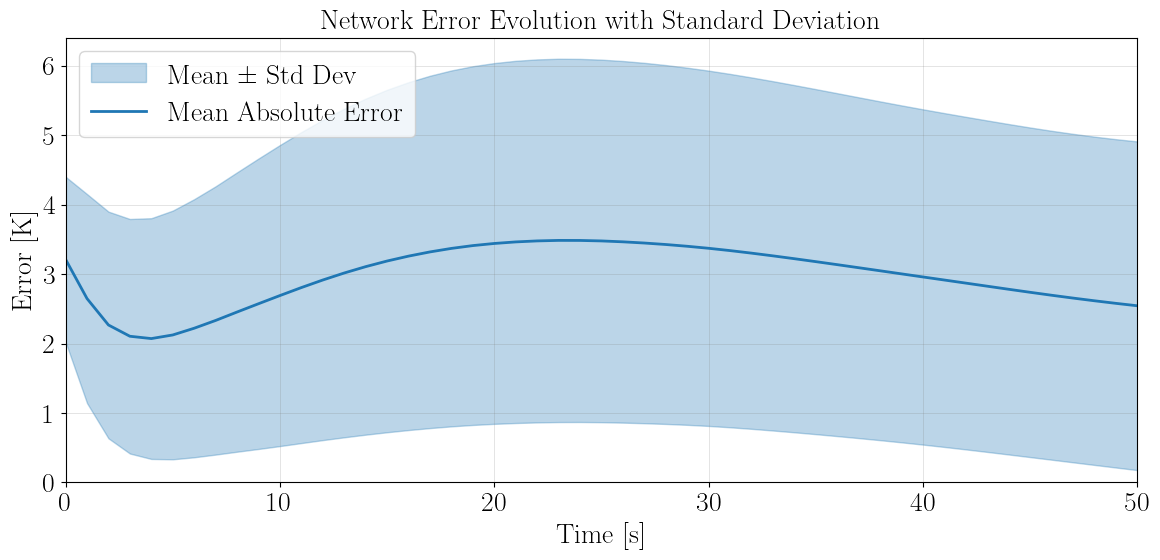

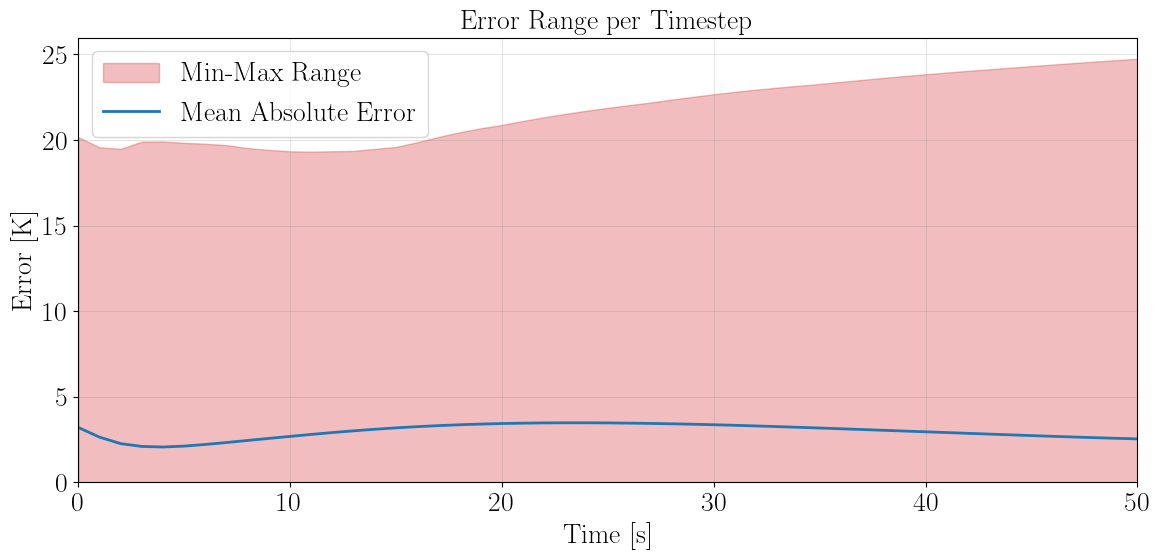

In [17]:
# Para pruebas rápidas, usar menos casos
mlp_results = calculate_mlp_error_by_timestep(
    model_mlp=model_mlp,
    dataset_mlp=dataset_mlp,
    T_transient_all=T_true_all,  # Solo primeros 100 casos
    Q_cases=Q_random,
    T_interfaces_cases=T_interfaces_random,
    T_env_cases=T_env_random,
    device=device,
    sequence_length=51
)

print(f"Error máximo en cualquier paso: {np.max(mlp_results['max_per_timestep']):.3f} K")

# Gráfica con bandas de desviación estándar
plot_error_with_std_bands(mlp_results, save_as_pdf=True, filename='error_with_std_bands_mlp')

# Gráfica separada del rango de error (min-max)
plot_error_range_per_timestep(mlp_results, save_as_pdf=True, filename='error_range_mlp')

### Spatio-Temporal Regressor with explicit time conditioning

In [18]:
from architectures.generic_spatiotemporal_regressor import GenericSpatioTemporalRegressor
from architectures.generic_spatiotemporal_decoder import *

embedding_dim = 128
num_layers = 1
nhead = 4
weigth_decay = 1e-4
dim_ff_factor = 5
dim_ff = dim_ff_factor * embedding_dim 
param_dropout = 0.2

class CustomTransformerDecoder(TransformerDecoder):
    def __init__(self, embedding_dim, num_layers, nhead, dim_ff, dropout):
        super().__init__(embedding_dim, num_layers, nhead)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
filename_regressor = f"PCB_TransformerRegressor_nt{n_train}_e{epochs}_{time_sim}s_lr{0.001}_bs{batch_size}_emb{embedding_dim}_lay{num_layers}_nhead{nhead}.pth"
model_dir_regressor = os.path.join(BASE_PATH, 'models', 'TransformerRegressor')
model_path_regressor = os.path.join(model_dir_regressor, filename_regressor)
json_path_regressor = model_path_regressor.replace('.pth', '.json')

# Instanciar el modelo
model_regressor = GenericSpatioTemporalRegressor(
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    nhead=nhead
).to(device)

model_regressor.temporal_decoder = CustomTransformerDecoder(
    embedding_dim=embedding_dim * 2, # lo hace así optuna
    num_layers=num_layers,
    nhead=nhead,
    dim_ff=dim_ff,
    dropout=param_dropout
).to(device)

model_regressor.load_state_dict(torch.load(model_path_regressor, map_location=device))

model_regressor.eval()
print() # solo para salto de línea

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_12448\1021726023.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_regressor.load_state_dict(torch.load(model_pat

🤖 Calculating regressor error by timestep
   📊 Cases: 1000
   ⏱️ Time steps: 51
   🔗 Sequence length: 51
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:02<00:00, 389.59it/s]



📊 REGRESSOR ERROR ANALYSIS RESULTS:
   Overall MAE: 4.869 K
   Overall RMSE: 8.682 K
   Overall STD: 7.176 K
   Initial timestep MAE: 3.717 K
   Final timestep MAE: 5.576 K
   Maximum timestep error: 5.576 K at t=50
Regressor - Error máximo en cualquier paso: 68.619 K


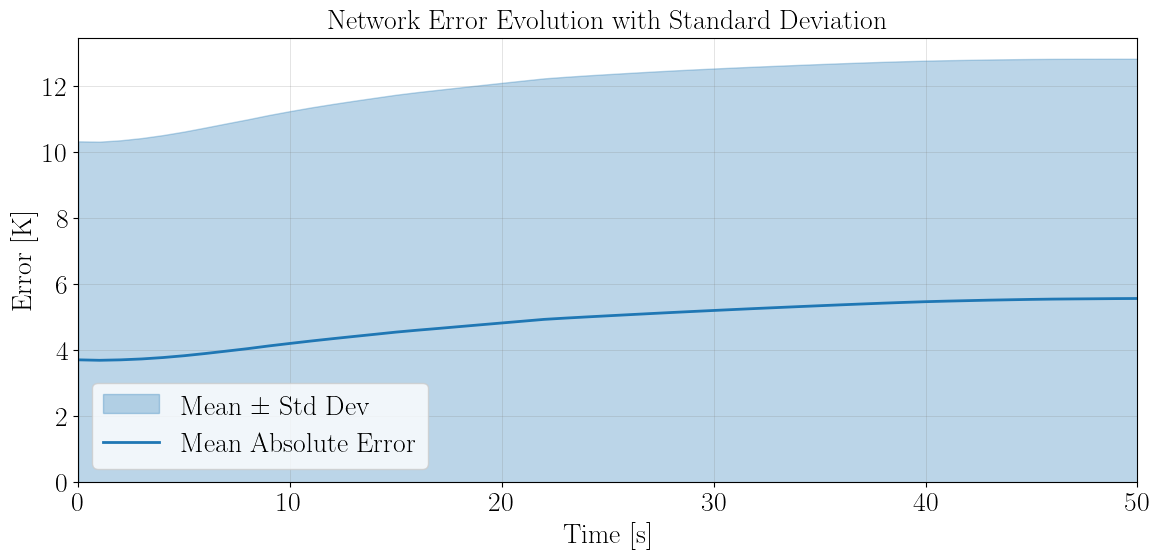

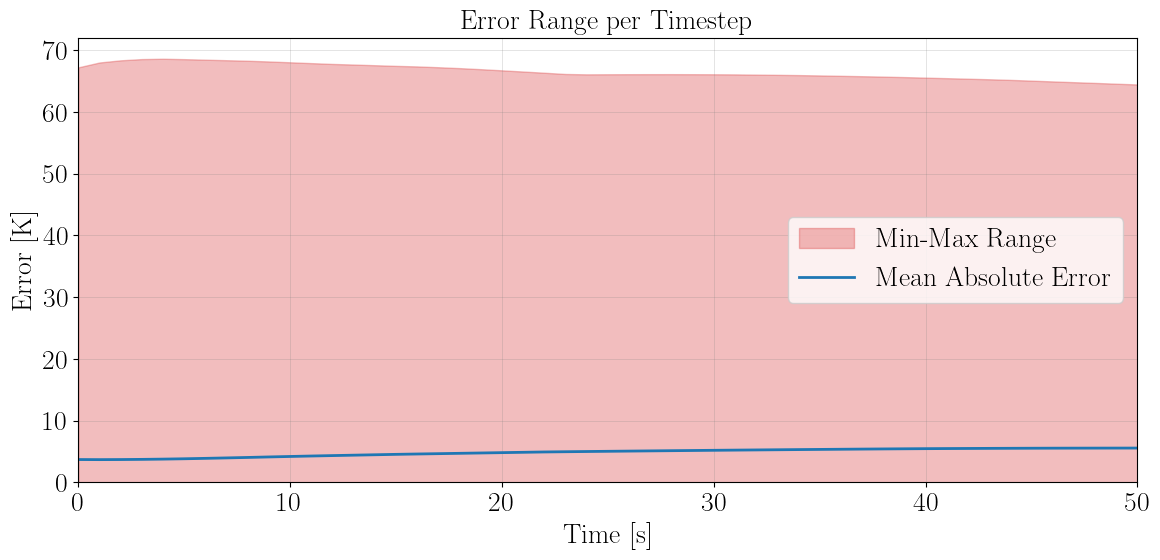

In [19]:
# Análisis del regressor
regressor_results = calculate_regressor_error_by_timestep(
    regressor=model_regressor,
    dataset=dataset,
    T_transient_all=T_true_all,
    Q_cases=Q_random,
    T_interfaces_cases=T_interfaces_random,
    T_env_cases=T_env_random,
    device=device,
    sequence_length=51
)

print(f"Regressor - Error máximo en cualquier paso: {np.max(regressor_results['max_per_timestep']):.3f} K")

# Visualizar resultados del regressor
plot_error_with_std_bands(regressor_results, save_as_pdf=True, filename='error_with_std_bands_regressor')
plot_error_range_per_timestep(regressor_results, save_as_pdf=True, filename='error_range_regressor')

### CNN Encoder

In [20]:
embedding_dim = 512
num_layers = 4
nhead = 8
use_temporal_channel = True

from architectures.generic_spatiotemporal_decoder import GenericSpatioTemporalDecoder

filename_encoder = f"PCB_Transformer_nt{n_train}_e{epochs}_{time_sim}s_lr{0.0001}_bs{batch_size}_emb{embedding_dim}_lay{num_layers}_nhead{nhead}.pth"
model_dir_encoder = os.path.join(BASE_PATH, 'models', 'TransformerDecoder')
model_path_encoder = os.path.join(model_dir_encoder, filename_encoder)
json_path_encoder = model_path_encoder.replace('.pth', '.json')

model_encoder = GenericSpatioTemporalDecoder(
    embedding_dim=embedding_dim,
    num_layers=num_layers,
    nhead=nhead,
    use_temporal_channel=use_temporal_channel
).to(device)

model_encoder.load_state_dict(torch.load(model_path_encoder, map_location=device))
model_encoder.eval()
print()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_12448\3704399444.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_encoder.load_state_dict(torch.load(model_path_

🧠 Calculating network error by timestep
   📊 Cases: 1000
   ⏱️ Time steps: 51
   🔗 Sequence length: 51
   🌐 Spatial nodes: 169 (13x13)


Processing cases:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_12448\207652059.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_pred = dataset.denormalize_output(torch.tensor(pred)).numpy()
Processing cases: 100%|██████████| 1000/1000 [00:08<00:00, 112.49it/s]



📊 NETWORK ERROR ANALYSIS RESULTS:
   Overall MAE: 3.977 K
   Overall RMSE: 6.640 K
   Overall STD: 5.286 K
   Initial timestep MAE: 2.650 K
   Final timestep MAE: 5.003 K
   Maximum timestep error: 5.086 K at t=48
Error máximo en cualquier paso: 50.829 K


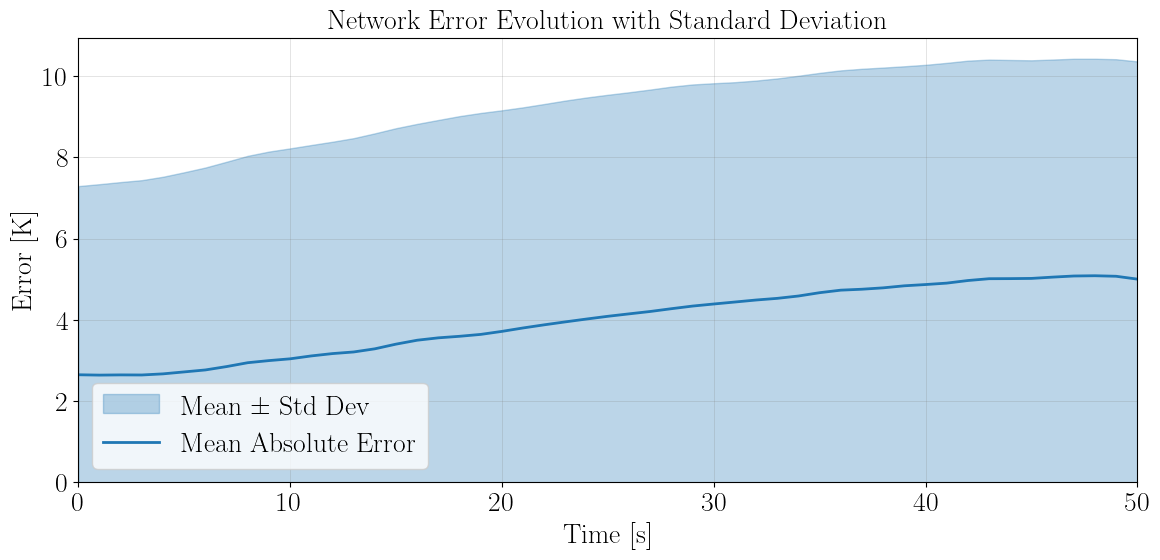

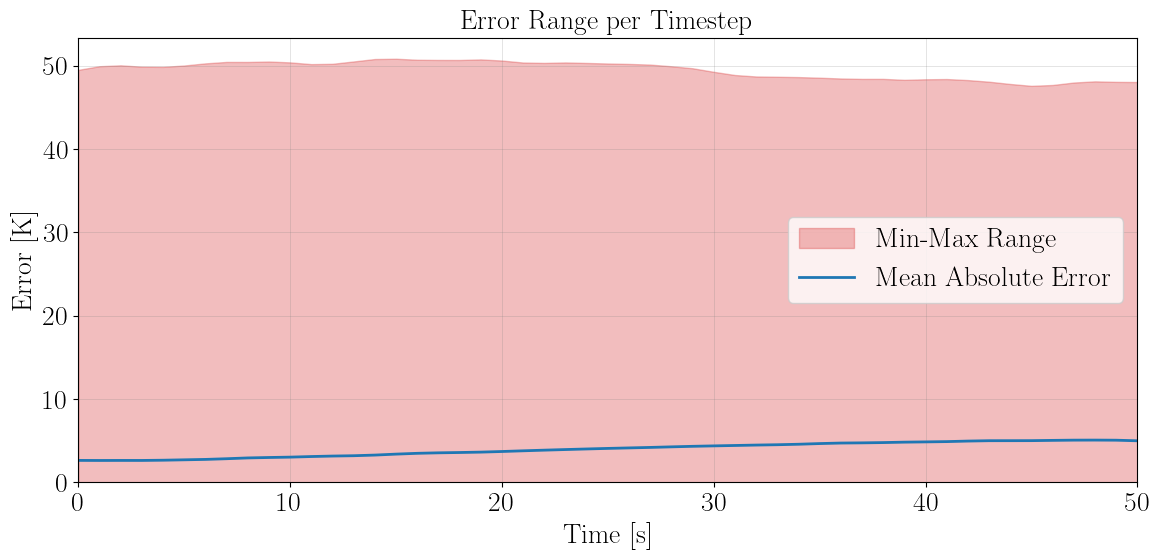

In [21]:
# 1. Análisis de un solo modelo
error_results = calculate_network_error_by_timestep(
    model=model_encoder,
    dataset=dataset,
    T_transient_all=T_true_all,
    Q_cases=Q_random,
    T_interfaces_cases=T_interfaces_random,
    T_env_cases=T_env_random,
    device=device
)
print(f"Error máximo en cualquier paso: {np.max(error_results['max_per_timestep']):.3f} K")

# Gráfica con bandas de desviación estándar
plot_error_with_std_bands(error_results, save_as_pdf=True, filename='error_with_std_bands_encoder')

# Gráfica separada del rango de error (min-max)
plot_error_range_per_timestep(error_results, save_as_pdf=True, filename='error_range_encoder')


### ConvLSTM

In [22]:
# 🧠 Arquitectura ConvLSTM
hidden_dims = [64, 64]                     # Número de filtros por capa
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers        # Kernel de cada capa (igual para todas)

class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13):
        super().__init__()
        self.height = height
        self.width = width
        self.num_layers = len(hidden_dims)

        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=self.num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x, hidden=None):
        """
        x      : (B, T, 6, H, W)
        hidden : lista de (h,c) por capa, o None
        returns: preds (B, T, 1, H, W), hidden
        """
        layer_output_list, hidden = self.convlstm(x, hidden)
        h_seq = layer_output_list[0]                # (B, T, hidden_dim, H, W)
        B, T, C_h, H, W = h_seq.shape

        h_flat = h_seq.contiguous().view(B*T, C_h, H, W)
        dec_flat = self.decoder(h_flat)
        preds = dec_flat.view(B, T, 1, H, W)
        return preds, hidden

    def forward_step(self, x_t, hidden=None):
        """
        Un paso de secuencia (seq_len=1).
        x_t    : (B, 1, 6, H, W)
        hidden : estado previo
        returns: pred (B, 1, 1, H, W), hidden
        """
        pred, hidden = self.forward(x_t, hidden)
        return pred, hidden
    

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = "-".join(str(d) for d in hidden_dims)

filename_convlstm = f"PCB_ConvLSTM_6ch_nt{n_data}_{time_sim}s_dt{dt}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
model_dir_convlstm = os.path.join(BASE_PATH, 'models', 'ConvLSTM_6ch', 'stateful_O2O')
model_path_convlstm = os.path.join(model_dir_convlstm, filename_convlstm)
json_path =  model_path_convlstm.replace('.pth', '.json')

model_convlstm = PCB_ConvLSTM(input_channels=6,
                     hidden_dims=hidden_dims,
                     kernel_size=kernel_size,
                     height=13,
                     width=13).to(device)
model_convlstm.load_state_dict(torch.load(model_path_convlstm, map_location=device))
model_convlstm.eval()
print()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_12448\3295620347.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_convlstm.load_state_dict(torch.load(model_path

🔄 Calculating ConvLSTM error by timestep (autoregressive)
   📊 Cases: 1000
   ⏱️ Time steps: 51
   🔗 Sequence length: 51
   🌐 Spatial nodes: 169 (13x13)


Processing cases: 100%|██████████| 1000/1000 [00:38<00:00, 26.14it/s]



📊 CONVLSTM ERROR ANALYSIS RESULTS:
   Overall MAE: 0.114 K
   Overall RMSE: 0.202 K
   Overall STD: 0.165 K
   Initial timestep MAE: 0.103 K
   Final timestep MAE: 0.170 K
   Maximum timestep error: 0.170 K at t=50
ConvLSTM - Error máximo en cualquier paso: 11.091 K


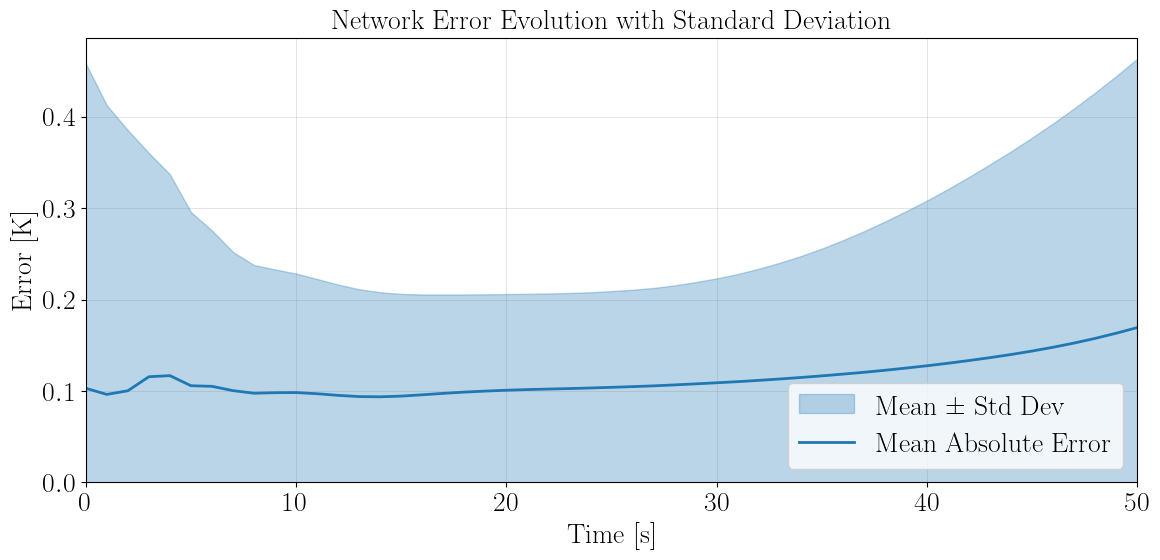

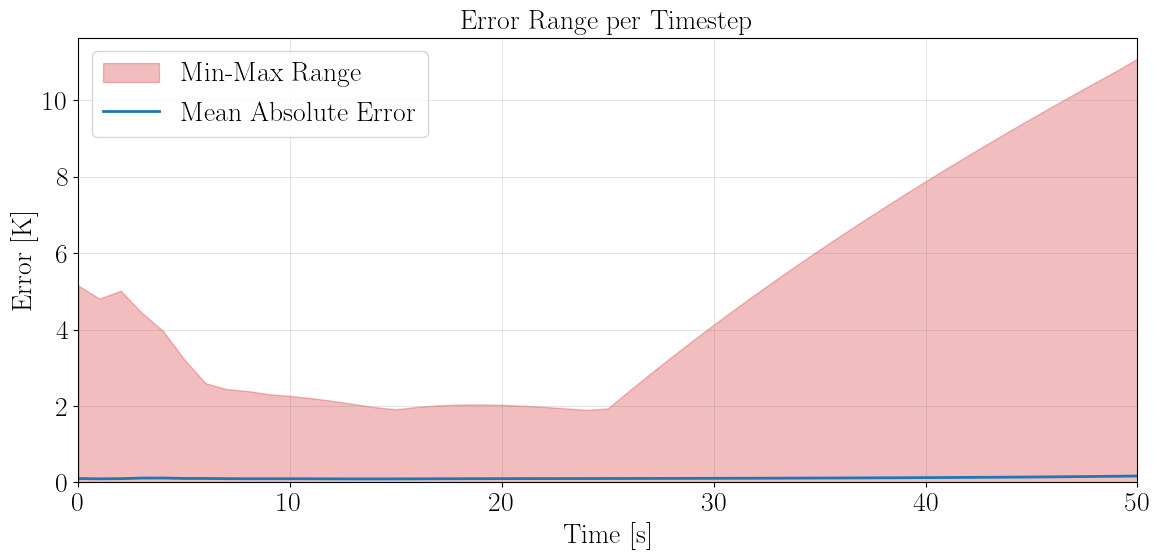

In [23]:
# Análisis del ConvLSTM
convlstm_results = calculate_convlstm_error_by_timestep(
    model=model_convlstm,
    dataset=dataset_convlstm,
    T_transient_all=T_true_all,
    Q_cases=Q_random,
    T_interfaces_cases=T_interfaces_random,
    T_env_cases=T_env_random,
    device=device,
    sequence_length=51
)

print(f"ConvLSTM - Error máximo en cualquier paso: {np.max(convlstm_results['max_per_timestep']):.3f} K")

# Visualizar resultados del ConvLSTM
plot_error_with_std_bands(convlstm_results, save_as_pdf=True, filename='error_with_std_bands_convlstm')
plot_error_range_per_timestep(convlstm_results, save_as_pdf=True, filename='error_range_convlstm')

## Comparison between all architectures

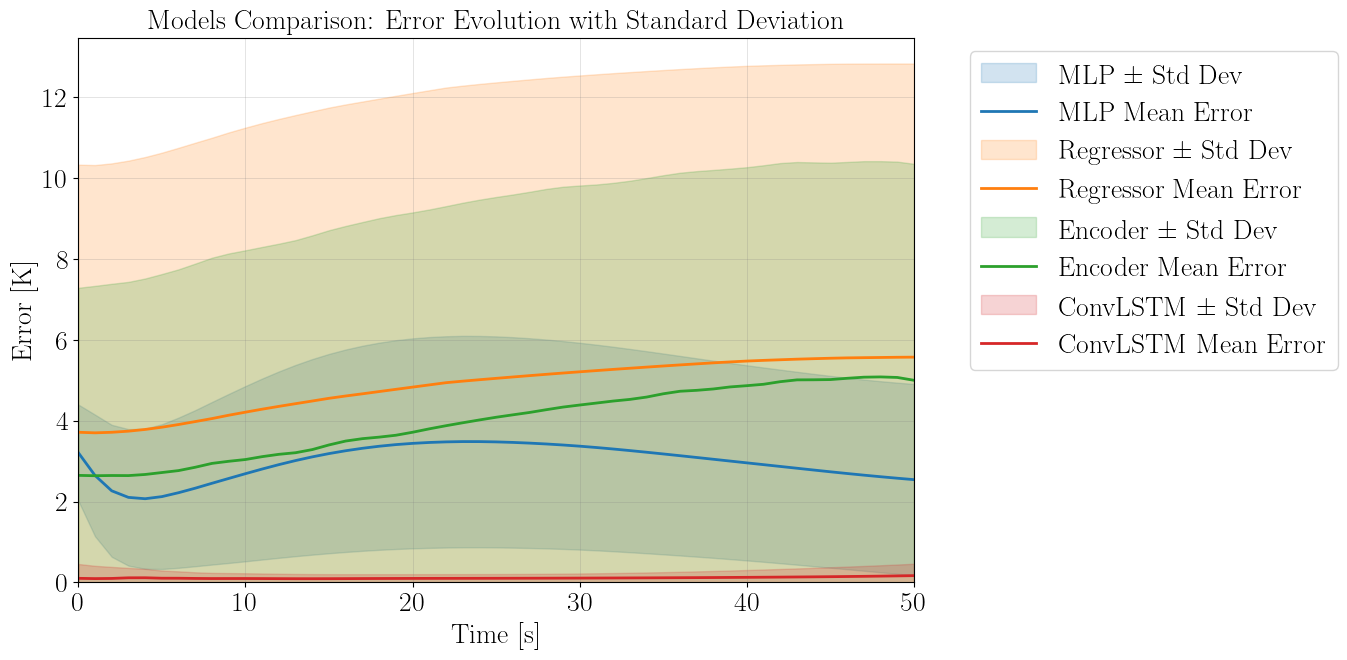

In [24]:
# Comparar con otros modelos
comparison_results = {
    'MLP': mlp_results,
    'Regressor': regressor_results,
    'Encoder': error_results,
    'ConvLSTM': convlstm_results
}

# Usar las funciones de comparación existentes
plot_models_comparison_with_std_bands(
    comparison_results, 
    save_as_pdf=True, 
    filename='all_architectures_comparison_bands'
)